initializing ocelot...


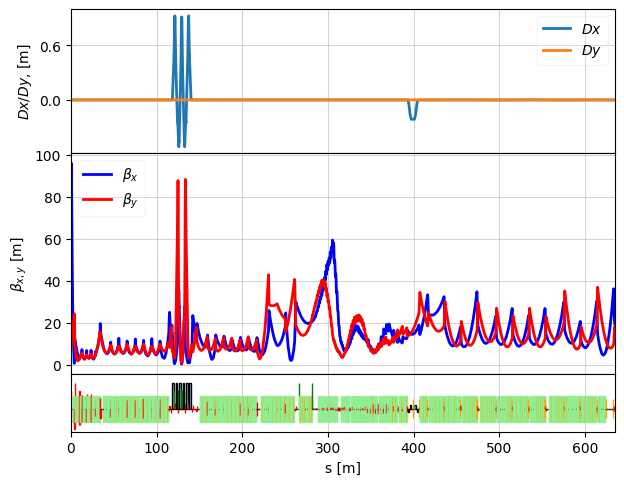

In [1]:
from ocelot import *
from ocelot.cpbd.elements import *
from ocelot.gui.accelerator import *
from ocelot.cpbd.track import track_debug
import matplotlib.pyplot as plt
import time


from rfglinacbte1 import *


lat = MagneticLattice(linac)


# --- Twiss setup ---
AX = -13.25; BX = 48.65; AY = -2.11; BY = 13.45
EMITX = 1.2e-6; EMITY = 1.2e-6
energy = 0.0328

tw0 = Twiss()
tw0.alpha_x = AX; tw0.beta_x = BX
tw0.alpha_y = AY; tw0.beta_y = BY
tw0.E = energy
tw0.emit_xn = EMITX; tw0.emit_yn = EMITY
tw0.emit_x = EMITX / energy * 0.511e-3
tw0.emit_y = EMITY / energy * 0.511e-3


tws = twiss(lat, tw0)

plot_opt_func(lat, tws, top_plot = ["Dx","Dy"], legend=False, font_size=10)
plt.show()


nparticles=100000
p_array=ParticleArray(n=nparticles)

charge = 2.0e-9 # 2 nC
sigma_tau = 1e-3 
sigma_p = 0.001 #SAD FILE

p_array.E = energy # GeV
p_array.rparticles[0] = np.zeros(nparticles)
p_array.rparticles[1] = np.zeros(nparticles)
p_array.rparticles[2] = np.zeros(nparticles)
p_array.rparticles[3] = np.zeros(nparticles)
p_array.rparticles[4] = np.random.randn(nparticles) * sigma_tau
p_array.rparticles[5] = np.random.randn(nparticles) * sigma_p
p_array.q_array = np.ones(nparticles) * charge / nparticles

for i in range(nparticles):
    p_array.rparticles[0][i], p_array.rparticles[1][i] = gauss_from_twiss(tw0.emit_x,tw0.beta_x, tw0.alpha_x )
    p_array.rparticles[2][i], p_array.rparticles[3][i] = gauss_from_twiss(tw0.emit_y,tw0.beta_y, tw0.alpha_y )

# # =============================================================================
# #  Tracking
# # =============================================================================


# # Create the Navigator
# navi = Navigator(lat)
# navi.unit_step = 0.1  # high-resolution steps


# # Track
# p_no = deepcopy(p_array)
# print("Tracking WITHOUT wake...")
# start = time.time()
# tws_no, p_no = track(lat, p_no, navi)
# print(f"No-wake track time: {time.time() - start:.2f}s")


In [2]:
from ocelot.cpbd.elements import Cavity
from copy import deepcopy

wt = WakeTable("corrected_bane_wake.txt")

# Base wake object
base_wake = Wake()
base_wake.w_sampling = 500
base_wake.wake_table = wt
base_wake.step = 1

navi = Navigator(lat)
navi.unit_step = 0.2

for elem in lat.sequence:
    if isinstance(elem, Cavity): 
        wake_copy = deepcopy(base_wake)
        navi.add_physics_proc(wake_copy, elem, elem)


# Track with wakes
p_array_t = deepcopy(p_array)
print("Tracking with wakes at all cavities ...")
start = time.time()
tws_track, p_array_t = track(lat, p_array_t, navi)
print("\nExecution time:", time.time() - start, "sec")

Tracking with wakes at all cavities ...
z = 634.9428243991842 / 634.9428243991842. Applied: ake, Wakeee
Execution time: 66.67631196975708 sec


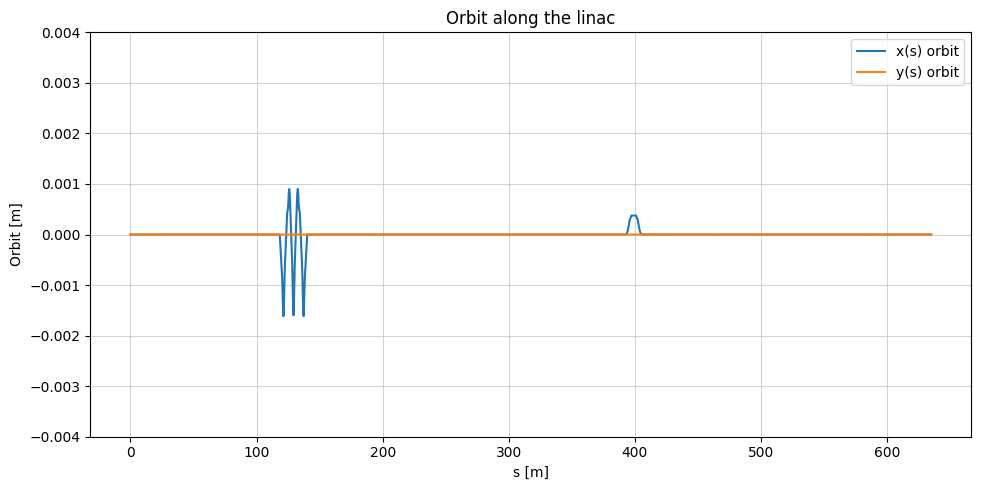

In [5]:
# --- Plot orbit ---
s = [tw.s for tw in tws_no]
x = [tw.x for tw in tws_no]
y = [tw.y for tw in tws_no]

plt.figure(figsize=(10,5))

plt.plot(s, x, label="x(s) orbit")
plt.plot(s, y, label="y(s) orbit")

plt.xlabel("s [m]")
plt.ylabel("Orbit [m]")
plt.title("Orbit along the linac")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.ylim(-0.004,0.004)
plt.show()


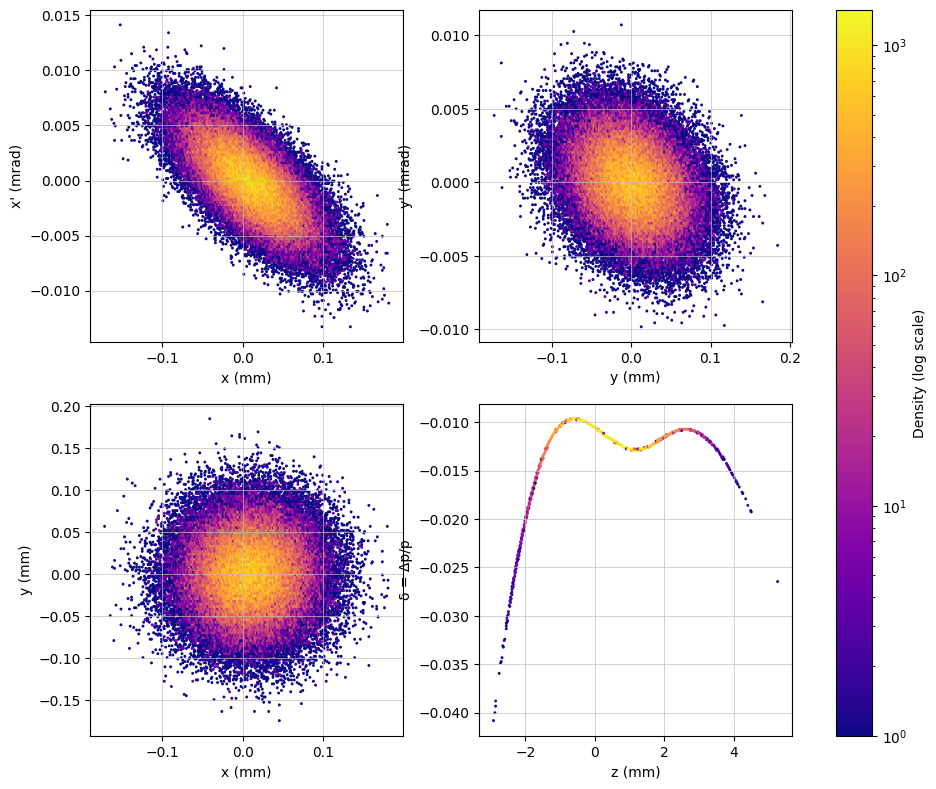

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract tracked particle coordinates
x  = p_array_t.rparticles[0] * 1e3       # mm
xp = p_array_t.rparticles[1] * 1e3       # mrad
y  = p_array_t.rparticles[2] * 1e3       # mm
yp = p_array_t.rparticles[3] * 1e3       # mrad
z  = p_array_t.rparticles[4] * 1e3       # mm
dp = p_array_t.rparticles[5]             # Δp/p (dimensionless)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# (a) x - x'
hb = axs[0,0].hexbin(x, xp, gridsize=200, cmap='plasma', bins='log')
axs[0,0].set_xlabel("x (mm)")
axs[0,0].set_ylabel("x' (mrad)")

# (b) y - y'
hb = axs[0,1].hexbin(y, yp, gridsize=200, cmap='plasma', bins='log')
axs[0,1].set_xlabel("y (mm)")
axs[0,1].set_ylabel("y' (mrad)")

# (c) x - y
hb = axs[1,0].hexbin(x, y, gridsize=200, cmap='plasma', bins='log')
axs[1,0].set_xlabel("x (mm)")
axs[1,0].set_ylabel("y (mm)")

# (d) z - δ
hb = axs[1,1].hexbin(z, dp, gridsize=200, cmap='plasma', bins='log')
axs[1,1].set_xlabel("z (mm)")
axs[1,1].set_ylabel("δ = Δp/p")

# Add colorbar
plt.tight_layout()
cbar = fig.colorbar(hb, ax=axs.ravel().tolist())
cbar.set_label("Density (log scale)")

plt.show()

In [2]:

# =============================================================================
#  TRANSVERSE ONLY CLASS
# =============================================================================

np.random.seed(60)

class TransverseOnlyWake(Wake):
    """Apply only transverse kicks (Px, Py), ignore longitudinal (Pz)."""
    def apply(self, p_array, dz):
        ps = p_array.rparticles
        Px, Py, Pz, I00 = self.add_total_wake(ps[0], ps[2], ps[4],
                                              p_array.q_array, self.TH,
                                              self.w_sampling, self.filter_order)
        L = self.s_stop - self.s_start
        frac = 1.0 if L == 0 else dz / L
        # apply ONLY transverse
        p_array.rparticles[3] += Py * frac * self.factor / (p_array.E * 1e9)
        p_array.rparticles[1] += Px * frac * self.factor / (p_array.E * 1e9)

def setup_navigator(lat, wakes=None, step=0.1):
    """Create a Navigator with optional wakes applied at all cavities."""
    navi = Navigator(lat)
    navi.unit_step = step
    
    if wakes:
        for wake in wakes:
            for elem in lat.sequence:
                if isinstance(elem, Cavity):
                    wake_copy = deepcopy(wake)
                    navi.add_physics_proc(wake_copy, elem, elem)
    return navi

def run_tracking(label, lat, p_array, navi):
    """Run tracking and report execution time."""
    p_copy = deepcopy(p_array)
    print(f"\n=== Tracking: {label} ===")
    start = time.time()
    tws, p_out = track(lat, p_copy, navi)
    print(f"{label} track time: {time.time() - start:.2f} s")
    return tws, p_out


In [3]:
# --- Transverse + Longitudinal wakes ---
# # --- Transverse wake only ---
wt_trans = WakeTable("transverse_only_wake.txt")
base_trans = TransverseOnlyWake()
base_trans.w_sampling = 500
base_trans.wake_table = wt_trans
base_trans.step = 1

# navi_trans = setup_navigator(lat, wakes=[base_trans])
# tws_trans, p_trans = run_tracking("Transverse wakes", lat, p_array, navi_trans)


# --- Transverse + Longitudinal wakes ---
wt_long = WakeTable("corrected_bane_wake.txt")
base_long = Wake()
base_long.w_sampling = 500
base_long.wake_table = wt_long
base_long.step = 1

navi_both = setup_navigator(lat, wakes=[base_trans, base_long])
tws_both, p_both = run_tracking("Transverse + Longitudinal wakes", lat, p_array, navi_both)


=== Tracking: Transverse + Longitudinal wakes ===
z = 634.9428243991842 / 634.9428243991842. Applied: Transverse + Longitudinal wakes track time: 107.56 s


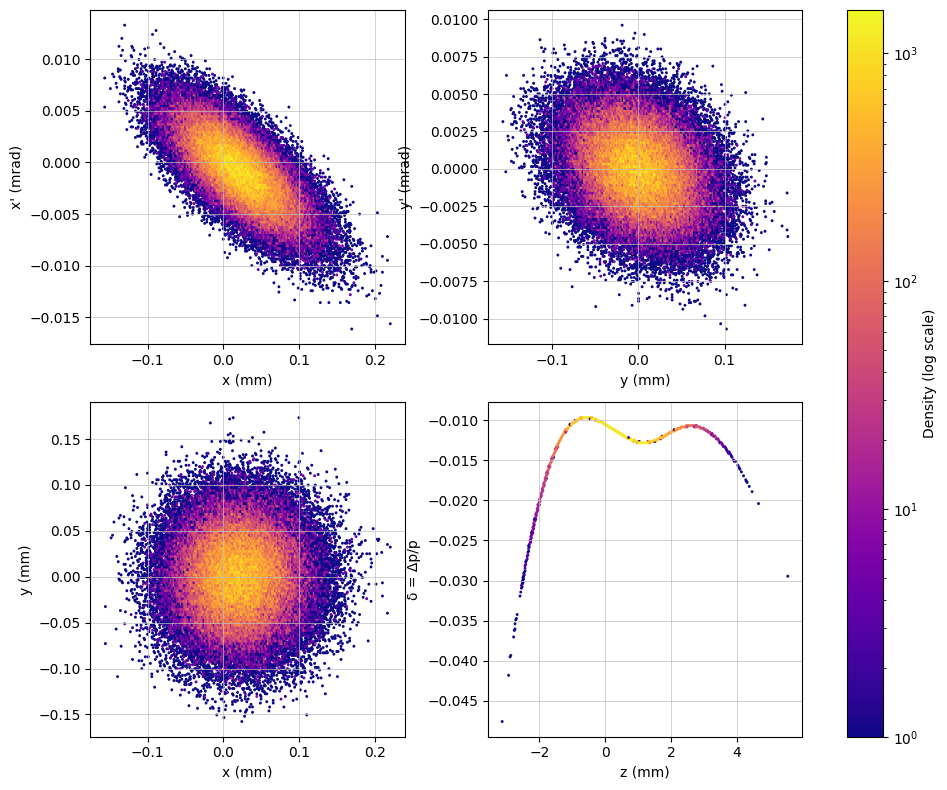

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Extract tracked particle coordinates
x  = p_both.rparticles[0] * 1e3       # mm
xp = p_both.rparticles[1] * 1e3       # mrad
y  = p_both.rparticles[2] * 1e3       # mm
yp = p_both.rparticles[3] * 1e3       # mrad
z  = p_both.rparticles[4] * 1e3       # mm
dp = p_both.rparticles[5]             # Δp/p (dimensionless)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# (a) x - x'
hb = axs[0,0].hexbin(x, xp, gridsize=200, cmap='plasma', bins='log')
axs[0,0].set_xlabel("x (mm)")
axs[0,0].set_ylabel("x' (mrad)")

# (b) y - y'
hb = axs[0,1].hexbin(y, yp, gridsize=200, cmap='plasma', bins='log')
axs[0,1].set_xlabel("y (mm)")
axs[0,1].set_ylabel("y' (mrad)")

# (c) x - y
hb = axs[1,0].hexbin(x, y, gridsize=200, cmap='plasma', bins='log')
axs[1,0].set_xlabel("x (mm)")
axs[1,0].set_ylabel("y (mm)")

# (d) z - δ
hb = axs[1,1].hexbin(z, dp, gridsize=200, cmap='plasma', bins='log')
axs[1,1].set_xlabel("z (mm)")
axs[1,1].set_ylabel("δ = Δp/p")

# Add colorbar
plt.tight_layout()
cbar = fig.colorbar(hb, ax=axs.ravel().tolist())
cbar.set_label("Density (log scale)")

plt.show()

# new (MAYBE WRONG)

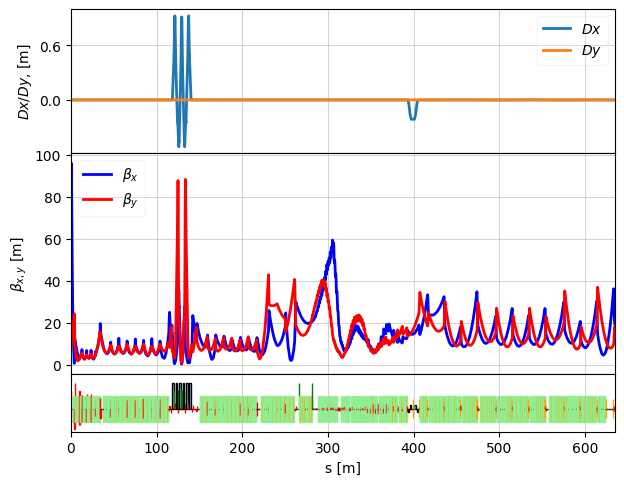

In [2]:
from ocelot import *
from ocelot.cpbd.elements import *
from ocelot.gui.accelerator import *
from ocelot.cpbd.track import track_debug
import matplotlib.pyplot as plt
import time


from rfglinacbte1 import *


lat = MagneticLattice(linac)


# --- Twiss setup ---
AX = -13.25; BX = 48.65; AY = -2.11; BY = 13.45
EMITX = 1.2e-6; EMITY = 1.2e-6
energy = 0.0328

tw0 = Twiss()
tw0.alpha_x = AX; tw0.beta_x = BX
tw0.alpha_y = AY; tw0.beta_y = BY
tw0.E = energy
tw0.emit_xn = EMITX; tw0.emit_yn = EMITY
tw0.emit_x = EMITX / energy * 0.511e-3
tw0.emit_y = EMITY / energy * 0.511e-3


tws = twiss(lat, tw0)

plot_opt_func(lat, tws, top_plot = ["Dx","Dy"], legend=False, font_size=10)
plt.show()


nparticles=100000
p_array=ParticleArray(n=nparticles)

charge = 2.0e-9 # 2 nC
sigma_tau = 1e-3 
sigma_p = 0.001 #SAD FILE

p_array.E = energy # GeV
p_array.rparticles[0] = np.zeros(nparticles)
p_array.rparticles[1] = np.zeros(nparticles)
p_array.rparticles[2] = np.zeros(nparticles)
p_array.rparticles[3] = np.zeros(nparticles)
p_array.rparticles[4] = np.random.randn(nparticles) * sigma_tau
p_array.rparticles[5] = np.random.randn(nparticles) * sigma_p
p_array.q_array = np.ones(nparticles) * charge / nparticles

for i in range(nparticles):
    p_array.rparticles[0][i], p_array.rparticles[1][i] = gauss_from_twiss(tw0.emit_x,tw0.beta_x, tw0.alpha_x )
    p_array.rparticles[2][i], p_array.rparticles[3][i] = gauss_from_twiss(tw0.emit_y,tw0.beta_y, tw0.alpha_y )


p_array.rparticles[0] += 50e-6
p_array.rparticles[2] += 50e-6


# # =============================================================================
# #  Tracking
# # =============================================================================


# # Create the Navigator
# navi = Navigator(lat)
# navi.unit_step = 0.1  # high-resolution steps


# # Track
# p_no = deepcopy(p_array)
# print("Tracking WITHOUT wake...")
# start = time.time()
# tws_no, p_no = track(lat, p_no, navi)
# print(f"No-wake track time: {time.time() - start:.2f}s")

In [32]:
import re

def extract_group_number(eid):
    """
    Extract the cavity group number from IDs like:
      ACA21, ACA212, ACB12, ACB122, ACC51, ACC512, AC1A, AC1B ...
    
    Rule:
      - capture the first one or two digits after the prefix.
      - if longer digits exist (212, 222), ignore the last digit (slice index)
    """
    m = re.search(r'[A-Z]+(\d+)', eid)
    if not m:
        return None
    
    digits = m.group(1)  # e.g. "21", "212", "51", "512"
    
    if len(digits) >= 3:
        return digits[:-1]   # "212" → "21", "512" → "51"
    return digits            # e.g. "21"


In [ ]:

# =============================================================================
#  TRANSVERSE ONLY CLASS
# =============================================================================

np.random.seed(60)

class TransverseOnlyWake(Wake):
    """Apply only transverse kicks (Px, Py), ignore longitudinal (Pz)."""
    def apply(self, p_array, dz):
        ps = p_array.rparticles
        Px, Py, Pz, I00 = self.add_total_wake(ps[0], ps[2], ps[4],
                                              p_array.q_array, self.TH,
                                              self.w_sampling, self.filter_order)
        L = self.s_stop - self.s_start
        frac = 1.0 if L == 0 else dz / L
        # apply ONLY transverse
        p_array.rparticles[3] += Py * frac * self.factor / (p_array.E * 1e9)
        p_array.rparticles[1] += Px * frac * self.factor / (p_array.E * 1e9)

def setup_navigator(lat, wakes=None, step=0.1):
    """Create a Navigator with optional wakes applied at all cavities."""
    navi = Navigator(lat)
    navi.unit_step = step
    
    if wakes:
        for wake in wakes:
            for elem in lat.sequence:
                if isinstance(elem, Cavity):
                    wake_copy = deepcopy(wake)
                    navi.add_physics_proc(wake_copy, elem, elem)
    return navi

def run_tracking(label, lat, p_array, navi):
    """Run tracking and report execution time."""
    p_copy = deepcopy(p_array)
    print(f"\n=== Tracking: {label} ===")
    start = time.time()
    tws, p_out = track(lat, p_copy, navi)
    print(f"{label} track time: {time.time() - start:.2f} s")
    return tws, p_out


In [34]:
# --- Transverse + Longitudinal wakes ---
# # --- Transverse wake only ---
wt_trans = WakeTable("transverse_only_wake.txt")
base_trans = TransverseOnlyWake()
base_trans.w_sampling = 500
base_trans.wake_table = wt_trans
base_trans.step = 1

# navi_trans = setup_navigator(lat, wakes=[base_trans])
# tws_trans, p_trans = run_tracking("Transverse wakes", lat, p_array, navi_trans)


# --- Transverse + Longitudinal wakes ---
wt_long = WakeTable("corrected_bane_wake.txt")
base_long = Wake()
base_long.w_sampling = 500
base_long.wake_table = wt_long
base_long.step = 1

navi_both = setup_navigator(lat, wakes=[base_trans, base_long])
tws_both, p_both = run_tracking("Transverse + Longitudinal wakes", lat, p_array, navi_both)


=== Tracking: Transverse + Longitudinal wakes ===
z = 634.9428243991842 / 634.9428243991842. Applied: Transverse + Longitudinal wakes track time: 50.24 s


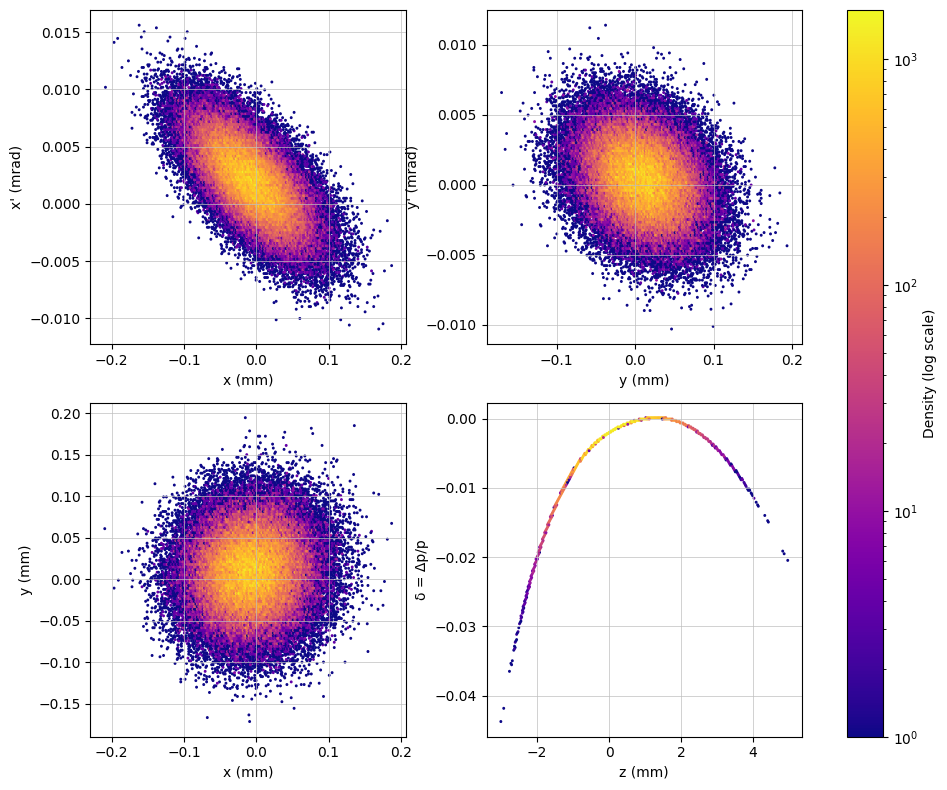

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Extract tracked particle coordinates
x  = p_both.rparticles[0] * 1e3       # mm
xp = p_both.rparticles[1] * 1e3       # mrad
y  = p_both.rparticles[2] * 1e3       # mm
yp = p_both.rparticles[3] * 1e3       # mrad
z  = p_both.rparticles[4] * 1e3       # mm
dp = p_both.rparticles[5]             # Δp/p (dimensionless)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# (a) x - x'
hb = axs[0,0].hexbin(x, xp, gridsize=200, cmap='plasma', bins='log')
axs[0,0].set_xlabel("x (mm)")
axs[0,0].set_ylabel("x' (mrad)")

# (b) y - y'
hb = axs[0,1].hexbin(y, yp, gridsize=200, cmap='plasma', bins='log')
axs[0,1].set_xlabel("y (mm)")
axs[0,1].set_ylabel("y' (mrad)")

# (c) x - y
hb = axs[1,0].hexbin(x, y, gridsize=200, cmap='plasma', bins='log')
axs[1,0].set_xlabel("x (mm)")
axs[1,0].set_ylabel("y (mm)")

# (d) z - δ
hb = axs[1,1].hexbin(z, dp, gridsize=200, cmap='plasma', bins='log')
axs[1,1].set_xlabel("z (mm)")
axs[1,1].set_ylabel("δ = Δp/p")

# Add colorbar
plt.tight_layout()
cbar = fig.colorbar(hb, ax=axs.ravel().tolist())
cbar.set_label("Density (log scale)")

plt.show()